# Home 3: Build a CNN for image recognition.

### Name: Erika Deckter


## 0. You will do the following:

1. Read, complete, and run the code.

2. **Make substantial improvements** to maximize the accurcy.
    
3. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain the code and the output after execution.
    
    
4. Upload this .HTML file to your Github repo.

4. Submit the link to this .HTML file to Canvas.

    * Example: https://github.com/wangshusen/CS583-2019F/blob/master/homework/HM3/HM3.html


## Requirements:

1. You can use whatever CNN architecture, including VGG, Inception, and ResNet. However, you must build the networks layer by layer. You must NOT import the archetectures from ```keras.applications```.

2. Make sure ```BatchNormalization``` is between a ```Conv```/```Dense``` layer and an ```activation``` layer.

3. If you want to regularize a ```Conv```/```Dense``` layer, you should place a ```Dropout``` layer **before** the ```Conv```/```Dense``` layer.

4. An accuracy above 70% is considered reasonable. An accuracy above 80% is considered good. Without data augmentation, achieving 80% accuracy is difficult.


## Google Colab

- If you do not have GPU, the training of a CNN can be slow. Google Colab is a good option.

- Keep in mind that you must download it as an IPYNB file and then use IPython Notebook to convert it to HTML.

- Also keep in mind that the IPYNB and HTML files must contain the outputs. (Otherwise, the instructor will not be able to know the correctness and performance.) Do the followings to keep the outputs.

- In Colab, go to ```Runtime``` --> ```Change runtime type``` --> Do NOT check ```Omit code cell output when saving this notebook```. In this way, the downloaded IPYNB file contains the outputs.

## 1. Data preparation

### 1.1. Load data


In [2]:
from keras.datasets import cifar10
import numpy

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print('shape of x_train: ' + str(x_train.shape))
print('shape of y_train: ' + str(y_train.shape))
print('shape of x_test: ' + str(x_test.shape))
print('shape of y_test: ' + str(y_test.shape))
print('number of classes: ' + str(numpy.max(y_train) - numpy.min(y_train) + 1))

Using TensorFlow backend.


170500096/170498071 [==============================] - 12s 0us/step
shape of x_train: (50000, 32, 32, 3)
shape of y_train: (50000, 1)
shape of x_test: (10000, 32, 32, 3)
shape of y_test: (10000, 1)
number of classes: 10


### 1.2. One-hot encode the labels

In the input, a label is a scalar in $\{0, 1, \cdots , 9\}$. One-hot encode transform such a scalar to a $10$-dim vector. E.g., a scalar ```y_train[j]=3``` is transformed to the vector ```y_train_vec[j]=[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]```.

1. Define a function ```to_one_hot``` that transforms an $n\times 1$ array to a $n\times 10$ matrix.

2. Apply the function to ```y_train``` and ```y_test```.

In [3]:
def to_one_hot(y, num_class=10):
    #Define number of rows in y
    rows = y.shape[0]
    #Define vector of all zeroes with dimension number of examples in y x number of classes
    one_hot = numpy.zeros((rows, num_class))
    #Update each row with a 1 for the column that corresponds to the label
    for row in range(rows):
        label = y[row]
        one_hot[row,label] = 1
    
    return one_hot

y_train_vec = to_one_hot(y_train)
y_test_vec = to_one_hot(y_test)

print('Shape of y_train_vec: ' + str(y_train_vec.shape))
print('Shape of y_test_vec: ' + str(y_test_vec.shape))

print(y_train[0])
print(y_train_vec[0])

Shape of y_train_vec: (50000, 10)
Shape of y_test_vec: (10000, 10)
[6]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


#### Remark: the outputs should be
* Shape of y_train_vec: (50000, 10)
* Shape of y_test_vec: (10000, 10)
* [6]
* [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]

### 1.3. Randomly partition the training set to training and validation sets

Randomly partition the 50K training samples to 2 sets:
* a training set containing 40K samples
* a validation set containing 10K samples


In [4]:
rand_indices = numpy.random.permutation(50000)
train_indices = rand_indices[0:40000]
valid_indices = rand_indices[40000:50000]

x_val = x_train[valid_indices, :]
y_val = y_train_vec[valid_indices, :]

x_tr = x_train[train_indices, :]
y_tr = y_train_vec[train_indices, :]

print('Shape of x_tr: ' + str(x_tr.shape))
print('Shape of y_tr: ' + str(y_tr.shape))
print('Shape of x_val: ' + str(x_val.shape))
print('Shape of y_val: ' + str(y_val.shape))

Shape of x_tr: (40000, 32, 32, 3)
Shape of y_tr: (40000, 10)
Shape of x_val: (10000, 32, 32, 3)
Shape of y_val: (10000, 10)


## 2. Build a CNN and tune its hyper-parameters

1. Build a convolutional neural network model
2. Use the validation data to tune the hyper-parameters (e.g., network structure, and optimization algorithm)
    * Do NOT use test data for hyper-parameter tuning!!!
3. Try to achieve a validation accuracy as high as possible.

### Remark: 

The following CNN is just an example. You are supposed to make **substantial improvements** such as:
* Add more layers.
* Use regularizations, e.g., dropout.
* Use batch normalization.

Original Image


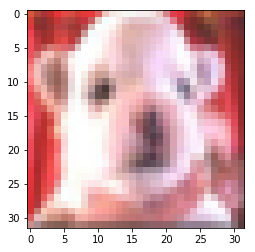

Random Augmentation of Image


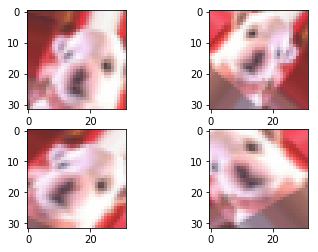

In [5]:
#This code performs data augmentation on the training images
from keras.preprocessing.image import ImageDataGenerator

#Create data generator function for training data that performs data augmentation
training_datagen = ImageDataGenerator(rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True)
#Training data generator for batches of 100 images from the training dataset
training_generator = training_datagen.flow(x_tr, y_tr, batch_size=50)

#Create data generator function for validation data (don't augment the validation data)
validation_datagen = ImageDataGenerator()
#Validation data generator for a single batch of all the validation data
validation_generator = validation_datagen.flow(x_val, y_val, batch_size=50)

#Show sample augmented training image
from keras.preprocessing import image
import matplotlib.pyplot as plt

#Select image to display
example = x_tr[1000]
#Show original image
print('Original Image')
plt.imshow(image.array_to_img(example))
plt.show()

#Show grid of four random augmentations of image
i = 1
test_image = example.reshape((1,) + example.shape)
fig = plt.figure()
for sample in training_datagen.flow(test_image, batch_size=1):
    fig.add_subplot(2,2,i)
    plt.imshow(image.array_to_img(sample[0]))
    i += 1
    if i % 5 == 0:
        break
print('Random Augmentation of Image')
plt.show()

In [6]:
#Build CNN using Keras
#Model based on the Inception module architecture
#as described in the paper "Going deeper with convolutions"
#https://arxiv.org/pdf/1409.4842.pdf

import tensorflow.keras.layers as layers
import tensorflow.keras.models as models
from tensorflow.keras import optimizers

#Define shape of input
image_shape = x_tr.shape[1:]
input_shape = layers.Input(shape = image_shape)

def inception_module(dimensions, module_input):
  x1 = layers.Conv2D(dimensions, (1,1), padding='same')(module_input)
  x1 = layers.BatchNormalization()(x1)
  x1 = layers.Activation('relu')(x1)
  x1 = layers.Conv2D(dimensions, (5,5), padding='same')(x1)
  x1 = layers.BatchNormalization()(x1)
  x1 = layers.Activation('relu')(x1)
  
  x2 = layers.Conv2D(dimensions, (1,1), padding='same')(module_input)
  x2 = layers.BatchNormalization()(x2)
  x2 = layers.Activation('relu')(x2)
  x2 = layers.Conv2D(dimensions, (3,3), padding='same')(x2)
  x2 = layers.BatchNormalization()(x2)
  x2 = layers.Activation('relu')(x2)
  
  x3 = layers.MaxPooling2D(3,3)(input_shape)
  x3 = layers.Conv2D(dimensions, (1,1), padding='same')(module_input)
  x3 = layers.BatchNormalization()(x3)
  x3 = layers.Activation('relu')(x3)
  
  x4 = layers.Conv2D(dimensions, (1,1), padding='same')(module_input)
  x4 = layers.BatchNormalization()(x4)
  x4 = layers.Activation('relu')(x4)
  
  module_output = layers.concatenate([x1, x2, x3, x4], axis=-1)
  
  return module_output

def build_model():
  conv_base = inception_module(64, input_shape)
  conv_base = inception_module(64, conv_base)
  conv_base = inception_module(64, conv_base)
  conv_base = inception_module(64, conv_base)
  conv_base = layers.MaxPooling2D(3,3)(conv_base)
  conv_base = inception_module(128, conv_base)
  conv_base = inception_module(128, conv_base)
  conv_base = inception_module(128, conv_base)
  conv_base = inception_module(128, conv_base)
  conv_base = layers.AveragePooling2D(3,3)(conv_base)

  #Add dense layers
  output = layers.Flatten()(conv_base)
  output = layers.Dropout(0.5)(output)
  output = layers.Dense(4096)(output)
  output = layers.BatchNormalization()(output)
  output = layers.Activation('relu')(output)
  output = layers.Dropout(0.5)(output)
  output = layers.Dense(10)(output)
  output = layers.BatchNormalization()(output)
  output = layers.Activation('softmax')(output)

  model = models.Model(inputs = input_shape, outputs = output)
  
  return model

#Show model architecture summary
build_model().summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   256         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 64)   256         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 64)   256         conv2d[0][0]                     
_____________

Learning Rate: 0.000100
Epoch 1/10
800/800 [==============================] - 366s 458ms/step - loss: 1.6972 - acc: 0.3921 - val_loss: 1.3382 - val_acc: 0.5380
Epoch 2/10
800/800 [==============================] - 348s 434ms/step - loss: 1.4421 - acc: 0.5055 - val_loss: 1.1934 - val_acc: 0.5891
Epoch 3/10
800/800 [==============================] - 347s 434ms/step - loss: 1.3120 - acc: 0.5594 - val_loss: 1.1501 - val_acc: 0.6124
Epoch 4/10
800/800 [==============================] - 347s 434ms/step - loss: 1.2147 - acc: 0.5986 - val_loss: 1.0312 - val_acc: 0.6606
Epoch 5/10
800/800 [==============================] - 347s 434ms/step - loss: 1.1398 - acc: 0.6302 - val_loss: 1.0004 - val_acc: 0.6677
Epoch 6/10
800/800 [==============================] - 346s 433ms/step - loss: 1.0722 - acc: 0.6542 - val_loss: 0.9110 - val_acc: 0.7064
Epoch 7/10
800/800 [==============================] - 346s 433ms/step - loss: 1.0092 - acc: 0.6790 - val_loss: 1.0718 - val_acc: 0.6448
Epoch 8/10
800/800 [====

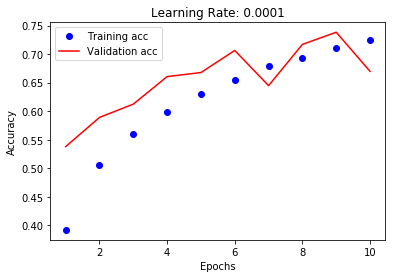

Learning Rate: 0.001000
Epoch 1/10
800/800 [==============================] - 365s 456ms/step - loss: 1.6263 - acc: 0.4156 - val_loss: 2.1014 - val_acc: 0.3888
Epoch 2/10
800/800 [==============================] - 347s 433ms/step - loss: 1.2552 - acc: 0.5666 - val_loss: 1.3554 - val_acc: 0.5612
Epoch 3/10
800/800 [==============================] - 347s 434ms/step - loss: 1.0838 - acc: 0.6292 - val_loss: 1.0667 - val_acc: 0.6505
Epoch 4/10
800/800 [==============================] - 347s 434ms/step - loss: 0.9762 - acc: 0.6665 - val_loss: 1.0886 - val_acc: 0.6381
Epoch 5/10
800/800 [==============================] - 346s 433ms/step - loss: 0.8842 - acc: 0.7023 - val_loss: 1.0398 - val_acc: 0.6794
Epoch 6/10
800/800 [==============================] - 346s 433ms/step - loss: 0.8236 - acc: 0.7204 - val_loss: 0.7216 - val_acc: 0.7623
Epoch 7/10
800/800 [==============================] - 346s 433ms/step - loss: 0.7637 - acc: 0.7429 - val_loss: 0.9732 - val_acc: 0.6934
Epoch 8/10
800/800 [====

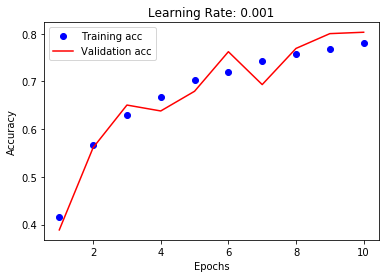

Learning Rate: 0.010000
Epoch 1/10
800/800 [==============================] - 367s 458ms/step - loss: 1.7851 - acc: 0.3396 - val_loss: 3.1774 - val_acc: 0.2970
Epoch 2/10
800/800 [==============================] - 346s 433ms/step - loss: 1.4594 - acc: 0.4700 - val_loss: 2.0801 - val_acc: 0.4070
Epoch 3/10
800/800 [==============================] - 347s 434ms/step - loss: 1.2901 - acc: 0.5372 - val_loss: 1.2667 - val_acc: 0.5768
Epoch 4/10
800/800 [==============================] - 348s 434ms/step - loss: 1.1639 - acc: 0.5894 - val_loss: 1.1558 - val_acc: 0.6183
Epoch 5/10
800/800 [==============================] - 347s 434ms/step - loss: 1.0706 - acc: 0.6249 - val_loss: 1.2217 - val_acc: 0.6086
Epoch 6/10
800/800 [==============================] - 349s 436ms/step - loss: 1.0039 - acc: 0.6503 - val_loss: 1.0377 - val_acc: 0.6491
Epoch 7/10
800/800 [==============================] - 348s 435ms/step - loss: 0.9422 - acc: 0.6750 - val_loss: 0.9139 - val_acc: 0.6991
Epoch 8/10
800/800 [====

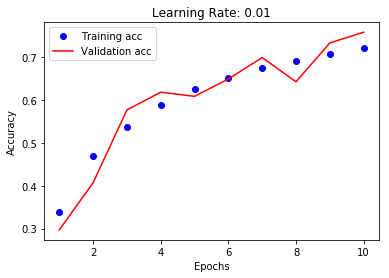

Learning Rate: 0.100000
Epoch 1/10
800/800 [==============================] - 374s 467ms/step - loss: 1.8740 - acc: 0.2991 - val_loss: 1.9062 - val_acc: 0.4148
Epoch 2/10
800/800 [==============================] - 348s 435ms/step - loss: 1.5456 - acc: 0.4322 - val_loss: 1.8136 - val_acc: 0.4372
Epoch 3/10
800/800 [==============================] - 348s 435ms/step - loss: 1.3976 - acc: 0.4937 - val_loss: 1.8510 - val_acc: 0.4655
Epoch 4/10
800/800 [==============================] - 348s 435ms/step - loss: 1.2969 - acc: 0.5347 - val_loss: 1.6017 - val_acc: 0.4928
Epoch 5/10
800/800 [==============================] - 348s 435ms/step - loss: 1.2122 - acc: 0.5685 - val_loss: 1.3612 - val_acc: 0.5641
Epoch 6/10
800/800 [==============================] - 348s 435ms/step - loss: 1.1491 - acc: 0.5936 - val_loss: 1.2808 - val_acc: 0.5804
Epoch 7/10
800/800 [==============================] - 348s 435ms/step - loss: 1.1018 - acc: 0.6122 - val_loss: 1.2071 - val_acc: 0.6188
Epoch 8/10
800/800 [====

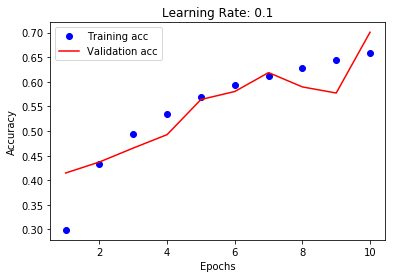

In [7]:
#Import matplotlib for plotting
import matplotlib.pyplot as plt
%matplotlib inline

#Build new model and summarize
learning_rates = [0.0001, 0.001, 0.01, 0.1]

for learning_rate in learning_rates:
  print('Learning Rate: {0:f}'.format(learning_rate))
  #Create new model
  cnn = build_model()
  
  #Compile with current learning rate
  cnn.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=learning_rate),
              metrics=['acc'])
  
  #Fit model using current learning rate
  history = cnn.fit_generator(training_generator,
                              steps_per_epoch = 800, 
                              epochs = 10, 
                              validation_data = validation_generator,
                              validation_steps = 200)
  
  #Plot training and validation accuracy
  acc = history.history['acc']
  val_acc = history.history['val_acc']

  epochs = range(1,len(acc)+1)

  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'r', label='Validation acc')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title('Learning Rate: '+str(learning_rate))
  plt.legend()
  plt.show()  

## 3. Train (again) and evaluate the model

- To this end, you have found the "best" hyper-parameters. 
- Now, fix the hyper-parameters and train the network on the entire training set (all the 50K training samples)
- Evaluate your model on the test set.

### 3.1. Train the model on the entire training set

Why? Previously, you used 40K samples for training; you wasted 10K samples for the sake of hyper-parameter tuning. Now you already know the hyper-parameters, so why not using all the 50K samples for training?

In [0]:
#Build and compile a final version of the model using the best learning rate
learning_rate=0.01

final_model = build_model()
final_model.compile(loss='categorical_crossentropy',
                    optimizer=optimizers.RMSprop(lr=learning_rate),
                    metrics=['acc'])

In [0]:
#Train final model using full training dataset
final_model.fit_generator(training_datagen.flow(x_train, y_train_vec, batch_size=50),
                          steps_per_epoch=1000,
                          epochs=10)

### 3.2. Evaluate the model on the test set

Do NOT use the test set until now. Make sure that your model parameters and hyper-parameters are independent of the test set.

In [0]:
loss_and_acc = final_model.evaluate(x_test, y_test_vec)
print('loss = ' + str(loss_and_acc[0]))
print('accuracy = ' + str(loss_and_acc[1]))